## Code submission

If you would like to use Jupyter (perhaps the easiest way, this replaces the old IJuliaNotebook), just submit the notebook file. Name it as p(Homework#).ipynb.  For instance, for homework 1, name it as p1.ipynb. I suggest everyone use the latest version of Julia (current stable version **v0.7.0**. Please **DO NOT** use v1.0.0 **unless you know what you are doing**).  

If you use MATLAB or Julia/Python (not the notebook), name your main program as p(Homework#)_(Problem#).m. For instance, for homework 1, problem 2, name it as p1_2.m (or p1_2.jl,p1_2.py). 

For proof-related problems, type your solution using **LaTeX (no other format is accepted)**. You do not need to write down every step of the derivation, but make sure the logic is clear.  

For implementation based problems, the problem description may not include all the information for the answer to be uniquely defined. For instance, your answer might depend on the choice of the mesh size. This is OK.

E-mail the codes above, and **any supporting files** for the homework to bCourses

You can **either** name it as

lastname_firstname_1.ipynb (if you **only** have a notebook file)

**or**

lastname_firstname_1.zip (if you have **more than one** files)

## Problem 1

Consider reaction-diffusion equation with periodic boundary condition

$$u_t(x,t) = u_{xx}(x,t) + \varepsilon u^2,\quad x\in [0,2\pi],$$

$$u(x,0)=e^{-5(x-\pi)^2}, \quad u(0,t)=u(2\pi,t), u_x(0,t)=u_x(2\pi,t).$$

Here $\varepsilon = 1.0$. Use second order finite difference discretization with uniform grid spacing $\Delta x=2\pi/100$.

Obtain the solution $u(x,T)$ at $T=6.0$ using the following methods.

a) Implement a `ForwardEuler` method, using the forward Euler for time discretization and $\Delta t=0.001$.

b) Implement a `CNBroyden` method, using a trapezoidal rule for time discretization and $\Delta t = 0.1$. This is also called the Crank-Nicolson method. Use any type of Broyden's method to solve the nonlinear equation. The starting guess for Broyden's matrix can be chosen as $B_0=\alpha I$, $\alpha=0.05$. Plot the number of iterations of Broyden's method for each step to reach certain stopping criterion (say $10^{-8}$).

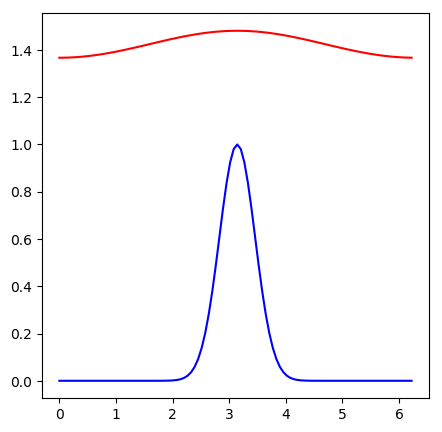

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002122F5F8>

In [5]:
using LinearAlgebra
using SparseArrays
#scheme
function ForwardEuler(Nt, T, u0, A, eps)
    m = length(u0)
    dt = T / Nt
    u = zeros(m, Nt + 1)
    u[:, 1] = u0
    t = dt * collect(0 : Nt)
    for i = 1 : Nt
        u[:, i + 1] = u[:, i] + dt * A * u[:, i] + dt * eps * u[:, i] .^ 2
    end
    return u
end

#setup for spatial discretization
L = 2 * pi
Nx = 100
dx = L / Nx
xq = dx * collect(0 : Nx - 1)
factor = 1 / dx ^ 2
A = factor * spdiagm(-1 => ones(Nx - 1), 0 => -2 * ones(Nx), 1 => ones(Nx - 1))
A[1, Nx] = factor
A[Nx, 1] = factor

#setup for timestepping
u0 = exp.(-5 * (xq .- pi) .^ 2)
T  = 6.0
dt = 0.001
Nt  = round(Int64, T / dt)
tq = dt * collect(0 : Nt)
eps = 1.0

uForwardEuler = ForwardEuler(Nt, T, u0, A, eps)

using PyPlot
figure(1, figsize = (5, 5))
plot(xq, vec(uForwardEuler[:, 1]), "b-")
plot(xq, vec(uForwardEuler[:, Nt]), "r-")

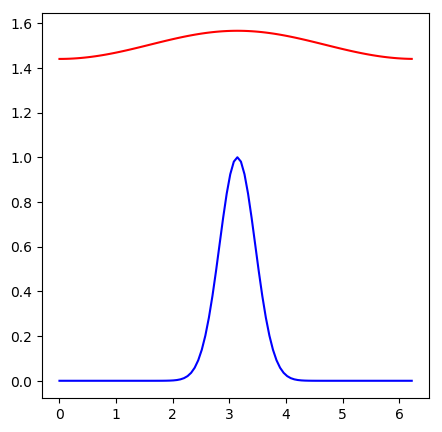

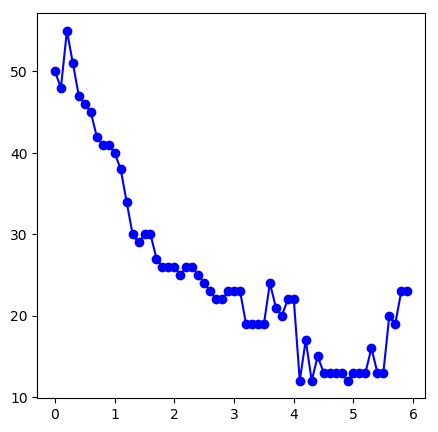

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000002311C7F0>

In [25]:
using LinearAlgebra

function CNBroyden(Nt, T, u0, A, eps, alpha, maxIter)
    m = length(u0)
    dt = T / Nt
    u = zeros(m, Nt + 1)
    u[:, 1] = u0
    t = dt * collect(0 : Nt)
    Niter = zeros(Nt)
    for i = 1 : Nt
        B = alpha * I
        ui = u[:, i]
        halftime = dt / 2
        previous = (I + halftime * A) * ui + halftime * eps * ui .* ui
        Fi = (I - halftime * A) * ui - halftime * eps * ui .* ui - previous
        uf = ui - B * Fi
        #nonlinear solver (Broyden's method)
        j = 0
        for k = 1 : maxIter
            j += 1
            F = (I - halftime * A) * uf - halftime * eps * uf .* uf - previous
            s = uf - ui
            y = F - Fi
            B = B + (s - B * y) * y' / norm(y) ^ 2
            ui = uf
            uf = uf - B * F
            Fi = F
            error = norm(uf - ui)
            if (error < 1e-8)
                break
            end
        end
        u[:, i + 1] = uf
        Niter[i] = j
    end
    return u, Niter
end

#setup for spatial discretization
L = 2 * pi
Nx = 100
dx = L / Nx
xq = dx * collect(0 : Nx - 1)
factor = 1 / dx ^ 2
A = factor * spdiagm(-1 => ones(Nx - 1), 0 => -2 * ones(Nx), 1 => ones(Nx - 1))
A[1, Nx] = factor
A[Nx, 1] = factor

#setup for timestepping
u0 = exp.(-5 * (xq .- pi) .^ 2)
T  = 6.0
dt = 0.1
Nt  = round(Int64, T / dt)
tq = dt * collect(0 : Nt)
eps = 1.0
alpha = 0.05
maxIter = 100

uCNBroyden, Niter = CNBroyden(Nt, T, u0, A, eps, alpha, maxIter)

using PyPlot
figure(1, figsize = (5, 5))
plot(xq, vec(uCNBroyden[:, 1]), "b-")
plot(xq, vec(uCNBroyden[:, end]), "r-")

figure(2, figsize = (5, 5))
plot(tq[1 : Nt], Niter, "b-o")

## Problem 2

Use the five-point finite difference formula and solve 

$$-\Delta u(x,y) = 1, \quad u\vert_{\partial \Omega} = 0,$$

on a $L$-shaped domain (see below, blue shaded region)

$$\Omega=((0,1)\times(0,1)) \backslash ([1/2,1]\times[1/2,1]).$$

Use a grid spacing $h=1/(N+1)$ and $N=200$. 

1) Write a function `FDLshape` which returns $X,Y,U$, so that $U_{i,j}$ is the approximate solution for $u(X[i,j],Y[i,j])$. If $(X[i,j],Y[i,j])$ is not in $\Omega$, $U_{i,j}=0$. Plot the solution $U$. You can solve the equation using the backslash directly.

2) Write a function `FDLshapeCG` which does the same job, but uses the conjugate gradient solver to solve the linear system and get the same result. You should write your own CG solver instead of using external packages.

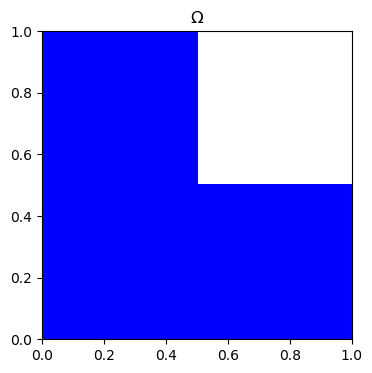

PyObject Text(0.5,1,'$\\Omega$')

In [27]:
function ndgrid(v1::AbstractVector{T}, v2::AbstractVector{T}) where T
    m, n = length(v1), length(v2)
    v1 = reshape(v1, m, 1)
    v2 = reshape(v2, 1, n)
    (repeat(v1, 1, n), repeat(v2, m, 1))
end

x1d=LinRange(0,1,100)
X,Y=ndgrid(x1d, x1d)
Z=zeros(size(X))
for j = 1 : prod(size(X))
    if(X[j] >= 0.5 && Y[j] >= 0.5)
        Z[j] = 1.0
    else
        Z[j] = 0.0
    end
end

using PyPlot
figure(1, figsize = (4, 4))
contourf(X, Y, Z, [0.00, 0.99, 1.01], colors = ("b", "w"))
title(L"\Omega")

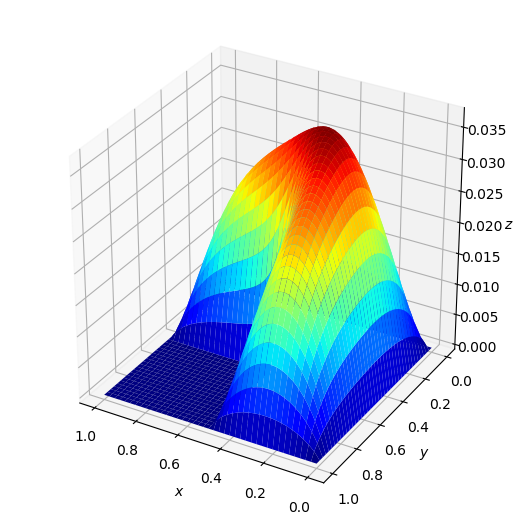

PyObject Text(0.0882737,0.0118264,'$z$')

In [68]:
using LinearAlgebra
using SparseArrays

function FDLShape(L,N)
    xq = 0 : L / N : L
    X, Y = ndgrid(xq, xq)
    U = zeros(size(Y))

    #this counting formula is from class
    Ncount = round(Int64, (N / 2 - 1) * (3 * N / 2 - 1))
    ind = zeros(Int64, Ncount)
    k = 0
    for i = 2 : N
        for j = 2 : N
            if(xq[i] < 0.5 || xq[j] < 0.5)
                k += 1
                ind[k] = j + (i - 1) * (N + 1)
            end
        end
    end
    
    #five-point central difference for Laplacian
    Ax = (N ^ 2 / (12 * L ^ 2)) * spdiagm(-2 => -ones(N - 1), -1 => 16 * ones(N), 0 => -30 * ones(N + 1), 1 => 16 * ones(N), 2 => -ones(N - 1))
    Axy = kron(sparse(I, N + 1, N + 1), Ax) + kron(Ax, sparse(I, N + 1, N + 1))
    A = Axy[ind, ind]
    f = ones(Ncount)
    u = A \ f
    U[ind] = -u
    return X, Y, U
end

X, Y, U = FDLShape(1, 200)
h = figure(1, figsize = (5, 5))
ax = Axes3D(h)
surf(X, Y, U, edgecolors = "none", cmap = ColorMap("jet"), shade = "true")
ax[:view_init](elev = 30, azim = 120)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")


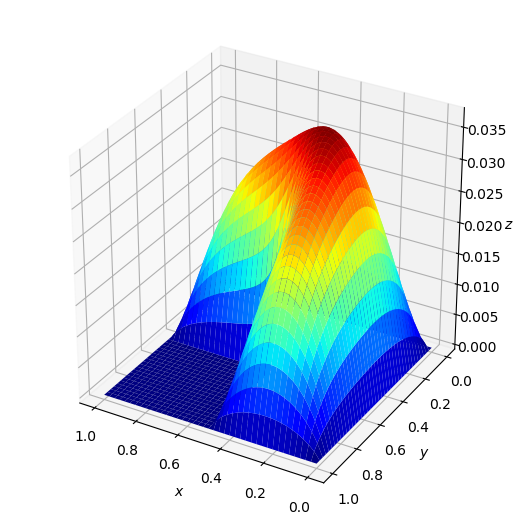

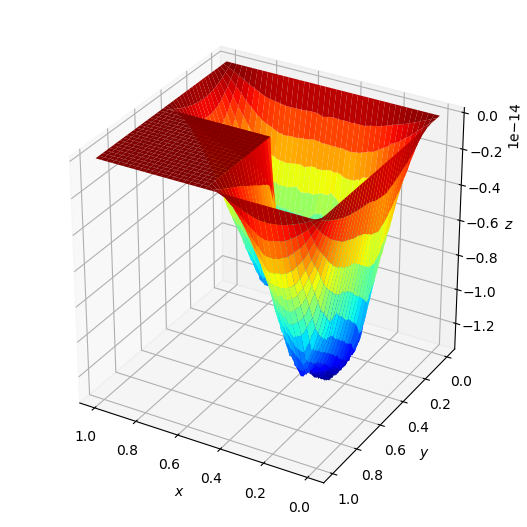

PyObject Text(0.0882737,0.0118264,'$z$')

In [69]:
using LinearAlgebra
using SparseArrays

function CG(A, b, x, tol = 1e-12, maxit = 1000)
    N = length(b)
    r = b - A * x
    p = r
    rdoti = dot(r, r)
    for i = 1 : maxit
        Ap = A * p
        α = rdoti / (p' * Ap)
        x = x + α * p
        r = r - α * Ap
        rdotf  = dot(r, r);
        if sqrt(rdotf) < tol
              break
        end
        p = r + (rdotf / rdoti) * p
        rdoti = rdotf
    end
    return x
end

function FDLShapeCG(L,N)
    xq = 0 : L / N : L
    X, Y = ndgrid(xq, xq)
    U = zeros(size(Y))

    #this counting formula is from class
    Ncount = round(Int64, (N / 2 - 1) * (3 * N / 2 - 1))
    ind = zeros(Int64, Ncount)
    k = 0
    for i = 2 : N
        for j = 2 : N
            if(xq[i] < 0.5 || xq[j] < 0.5)
                k += 1
                ind[k] = j + (i - 1) * (N + 1)
            end
        end
    end
    
    #five-point central difference for Laplacian
    Ax = (N ^ 2 / (12 * L ^ 2)) * spdiagm(-2 => -ones(N - 1), -1 => 16 * ones(N), 0 => -30 * ones(N + 1), 1 => 16 * ones(N), 2 => -ones(N - 1))
    Axy = kron(sparse(I, N + 1, N + 1), Ax) + kron(Ax, sparse(I, N + 1, N + 1))
    A = Axy[ind, ind]
    f = ones(Ncount)
    u = CG(A, f, zeros(Int64, Ncount))
    U[ind] = -u
    return X, Y, U
end

X, Y, UCG = FDLShapeCG(1, 200)
h = figure(1, figsize = (5, 5))
ax = Axes3D(h)
surf(X, Y, UCG, edgecolors = "none", cmap = ColorMap("jet"), shade = "true")
ax[:view_init](elev = 30, azim = 120)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")

h = figure(2, figsize = (5, 5))
ax = Axes3D(h)
surf(X, Y, U - UCG, edgecolors = "none", cmap = ColorMap("jet"), shade = "true")
ax[:view_init](elev = 30, azim = 120)
xlabel(L"x")
ylabel(L"y")
zlabel(L"z")

The conjugate gradient solver actually took *longer* to solve the linear system than A\b did, but if we were working with a denser and/or larger grid, the CGS would eventually become more comparably efficient.

## Problem 3

Consider a matrix $A\in \mathbb{R}^{N\times N}$. $A$ is diagonalizable with only two distinct eigenvalues $\pm 1$. Prove that for any right hand side $b$ and initial guess $x_0$, GMRES solves the equation $Ax=b$ with at most 2 iterations.

___
**Note:** Along with the lecture notes for this course, for completing this proof, I also referenced *Iterative Methods for Linear and Nonlinear Equations* by C. T. Kelley. In particular, I consulted chapter 3: GMRES Iteration.

**Proof:** In GMRES, the residual at the $m$th iteration is defined as $r_{m}=b-Ax_{m}$, since we originally wanted to solve $Ax=b$. Note that, furthermore, the goal of GMRES is to find an $x_{m}=x_{0}+V_{m}y_{m}$, such that the norm $\left\|b-Ax_{m}\right\|$ is minimized. Thus, we also have that 

$$
r_{m}=b-A\left(x_{0}+V_{m}y_{m}\right)=b-Ax_{0}-AV_{m}y_{m} \\ \Rightarrow r_{m}=r_{0}-AV_{m}y_{m} \hspace{0.5cm} (1)
$$ 

Furthermore, by Arnoldi iteration, $V_{m}$ is the matrix whose $m$ column vectors form an orthonormal basis for $K_{m}=span\left\{r_{0},Ar_{0},\dots,A^{m-1}r_{0}\right\}$, and $y_{m}\in\mathbb{R}^{m}$. Therefore, $V_{m}y_{m}=p_{m-1}(A)r_{0}$, for some $p_{m-1}\in\mathbb{P}^{m-1}$ (i.e. the space of $(m-1)$th degree polynomials), and $(1)$ becomes:

$$
r_{m}=r_{0}-Ap_{m-1}(A)r_{0}=\left(I-Ap_{m-1}(A)\right)r_{0} \hspace{0.5cm} (2)
$$

$I$ is the $N\times N$ identity matrix. Since $p_{m-1}(A)=\sum _{j=1}^{m}{c_{j}A^{j-1}}$ for arbitrary coefficients $c_{i}\in\mathbb{R}$, $i\in\left\{1,\dots,m\right\}$, we have that $Ap_{m-1}(A)=A\sum _{j=1}^{m}{c_{j}A^{j-1}}=\sum _{j=1}^{m}{c_{j}A^{j}}$. Therefore, we can define $I-\sum _{j=1}^{m}{c_{j}A^{j}}:=q_{m}(A)$ for $q_{m}\in\mathbb{P}^{m}$, and with this, $(2)$ becomes

$$
r_{m}=q_{m}(A)r_{0} \Rightarrow \left\|r_{m}\right\|=\left\|q_{m}(A)r_{0}\right\|\leq\left\|q_{m}(A)\right\|\left\|r_{0}\right\| \hspace{0.5cm} (3)
$$

For the last step, we used the Cauchy-Schwarz inequality. Before moving on, we prove a small lemma for diagonalizable matrices.

*Lemma:* For $A\in\mathbb{R}^{N\times N}$, suppose that we have $A=PDP^{-1}$ for some diagonal matrix $D\in\mathbb{R}^{N\times N}$ and invertible matrix $P\in\mathbb{R}^{N\times N}$ (i.e. suppose that $A$ is diagonalizable). Then, $A^{n}=PD^{n}P^{-1}$ $\forall n\in\mathbb{N}$.

*Proof of lemma:* We proceed by induction. Clearly, the base case holds, since for $n=1$, $A=PDP^{-1}$. Now, for our inductive hypothesis, suppose that $A^{k}=PD^{k}P^{-1}$ for some $k\in\mathbb{N}$. Then, $A^{k+1}=A\left(A^{k}\right)=A\left(PD^{k}P^{-1}\right)=\left(PDP^{-1}\right)\left(PD^{k}P^{-1}\right)=PD\left(P^{-1}P\right)D^{k}P^{-1}=pDID^{k}P^{-1}=\boxed{PD^{k+1}P^{-1}}$. Q.E.D.

In our original problem, since $A$ is diagonalizable, there exists a diagonal matrix $D\in\mathbb{R}^{N\times N}$ and invertible matrix $P\in\mathbb{R}^{N\times N}$ such that $A=PDP^{-1}$, where $D$ contains all of the eigenvalues for $A$, and $P$ their corresponding eigenvectors. Substituting this into our definition of $q_{m}(A)$, and using the lemma we have just proven, we now have that 

$$
q_{m}(A)=I-\sum _{j=1}^{m}{c_{j}\left(PDP^{-1}\right)^{j}}=PIP^{-1}-\sum _{j=1}^{m}{c_{j}PD^{j}P^{-1}}=P\left(I-\sum _{j=1}^{m}{c_{j}D^{j}}\right)P^{-1} \hspace{0.5cm} (4)
$$

Combining $(3)$ and $(4)$, and using the Cauchy-Schwarz inequality yet again, we finally have that

$$
\left\|r_{m}\right\|\leq\left\|P\left(I-\sum _{j=1}^{m}{c_{j}D^{j}}\right)P^{-1}\right\|\left\|r_{0}\right\|\leq\left\|P\right\|\left\|P^{-1}\right\|\left\|I-\sum _{j=1}^{m}{c_{j}D^{j}}\right\|\left\|r_{0}\right\| \hspace{0.5cm} (5)
$$

Of course, $I-\sum _{j=1}^{m}{c_{j}D^{j}}\equiv q_{m}(D)$, and $\left\|P\right\|\left\|P^{-1}\right\|:=\kappa\left(P\right)$, where $\kappa\left(P\right)$ is the condition number for $P$. With these and $(5)$, we get this final inequality:

$$
\left\|r_{m}\right\|\leq\kappa\left(P\right)\left\|q_{m}(D)\right\|\left\|r_{0}\right\| \hspace{0.5cm} (6)
$$

GMRES is designed such that the norm $\left\|b-Ax_{m}\right\|\equiv\left\|r_{m}\right\|$ is minimized at each iteration, which implies by $(3)$ that $\left\|q_{m}(D)\right\|$ is minimized at each $m$th iteration. Thus, in particular, $(6)$ implies that

$$
\left\|r_{m}\right\|\leq\kappa\left(P\right)\left\|r_{0}\right\|\underset{q\in\mathbb{P}^{m}}{\min}\left\|q(D)\right\| \hspace{0.5cm} (7)
$$

We note that $D$ is a diagonal matrix containing the eigenvalues $\lambda_{1},\dots,\lambda_{N}$ for $A$, so $D^{n}=\begin{pmatrix} {\lambda}_{1}^{n} & 0 & \cdots  & 0 \\ 0 & {\lambda}_{2}^{n} & \ddots  & \vdots  \\ \vdots  & \ddots  & \ddots  & 0 \\ 0 & \cdots  & 0 & {\lambda}_{N}^{n} \end{pmatrix}$, and since $\lambda_{i}\in\{-1,1\} \forall i\in\{1,\dots,N\}$, 

$$
D^{2}=\begin{pmatrix} {\lambda}_{1}^{2} & 0 & \cdots  & 0 \\ 0 & {\lambda}_{2}^{2} & \ddots  & \vdots  \\ \vdots  & \ddots  & \ddots  & 0 \\ 0 & \cdots  & 0 & {\lambda}_{N}^{2} \end{pmatrix}=\begin{pmatrix} 1 & 0 & \cdots  & 0 \\ 0 & 1 & \ddots  & \vdots  \\ \vdots  & \ddots  & \ddots  & 0 \\ 0 & \cdots  & 0 & 1 \end{pmatrix}=I \hspace{0.5cm} (8)
$$

By $(8)$, if $c_{1}=0$ and $c_{2}=1$, then $q_{2}(D)=I-c_{1}D-c_{2}D^{2}=I-0-D^{2}=I-I=0$. Therefore, this indeed must be a minimizing polynomial for $m=2$, since by definition of norm, $\left\|q_{2}(z)\right\|\geq 0\hspace{0.15cm} \forall z\in\mathbb{R}^{N\times N}$. We also note that, for $m=1$, $\nexists q_{1}\in\mathbb{P}^{1}$ such that $\left\|q_{m}(D)\right\|=\left\|q_{1}(D)\right\|=0$. This is because we would need simultaneously that $1-c_{1}=0$ and $1+c_{1}=0$, which implies that $0=1-c_{1}+1+c_{1}=2$, a contradiction. Thus, GMRES *might* not solve $Ax=b$ in only one iteration.

Still though, this implies that $\underset{q\in\mathbb{P}^{2}}{\min}\left\|q(D)\right\|=0$, so plugging this into $(7)$ with $m=2$, we have that

$$
0\leq\left\|r_{2}\right\|\leq\kappa\left(P\right)\left\|r_{0}\right\|\underset{q\in\mathbb{P}^{2}}{\min}\left\|q(D)\right\|=\kappa\left(P\right)\left\|r_{0}\right\|(0)=0 \Rightarrow \left\|r_{2}\right\|=\left\|b-Ax_{2}\right\|=0 \\ \Rightarrow \boxed{\therefore Ax_{2}=b}
$$

Therefore, GMRES solves $Ax=b$ in *at most* two iterations. Q.E.D.

## Problem 4

The nonlinear Schrodinger equation in 1D

$$\imath \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t), \quad x\in \mathbb{R}$$

has an exact solution  

$$\psi_{exact}(x,t) = \frac{2a}{\beta} \text{sech}\left[\sqrt{a}(x-x_0-ct)\right] \exp\left[\imath \frac{c}{2}(x-x_0)-\imath\left(\frac{c^2}{4}-a\right)t\right].$$

Here we choose the parameter

$\beta=-8.0,a=\beta^2/16,c=0.5,x_0=-3.0$.


Solve this problem on a finite sized domain $[-L/2,L/2]$ with $L=20$ and periodic boundary condition. Use the central finite difference scheme for spatial discretization. 

(1) Write a routine `rk4` to compute the solution at $T_f=1.0$ using the RK4 method. You need to choose the grid size (spatial and temporal) so that the maximum absolute error of the solution (by comparing to the exact solution) is less than $10^{-3}$.

(2) Write a routine `IMEX` to do the same thing with the IMEX method, where the implicit scheme is chosen to be the trapezoidal rule, and the explicit scheme is AB2.  If there is a linear system to be solved, use GMRES to solve the linear system.

___
**Part 1:** To apply RK4 (i.e. *the* Runge-Kutta method) to the 1D nonlinear Schrödinger equation, we first write it in a more usable form, so that the term with the time derivative is by itself.

$$
i \partial_t u(x,t) = -\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t) \\ -i\left(i \partial_t u(x,t)\right) = -i\left(-\partial_{xx} u(x,t)+\beta \vert u(x,t)\vert^2 u(x,t)\right) \\ \Rightarrow \partial_t u(x,t) = i\left(\partial_{xx} u(x,t)-\beta \vert u(x,t)\vert^2 u(x,t)\right) \hspace{0.5cm} (1)
$$

Next, we look at the time evolution of $(1)$ at some grid point $x=x_{i}$.

$$
\partial_t u(x_{i},t) = i\left(\partial_{xx} u(x,t)\vert_{x=x_{i}}-\beta \vert u(x_{i},t)\vert^2 u(x_{i},t)\right) \hspace{0.5cm} (2)
$$

As given in the problem, we use a central finite difference scheme with an appropriate stepsize $\Delta x$ in position to approximate $\partial_{xx} u(x,t)\vert_{x=x_{i}}\approx\frac{u\left(x_{i}+\Delta x,t\right)-2u\left(x_{i},t\right)+u\left(x_{i}-\Delta x,t\right)}{\left(\Delta x\right)^{2}}$, which turns $(2)$ into

$$
\partial_t u(x_{i},t) \approx i\left(\frac{u\left(x_{i}+\Delta x,t\right)-2u\left(x_{i},t\right)+u\left(x_{i}-\Delta x,t\right)}{\left(\Delta x\right)^{2}}-\beta \vert u(x_{i},t)\vert^2 u(x_{i},t)\right) \\ \Rightarrow \partial_t u(x_{i},t) \approx=i\left(\frac{u\left(x_{i+1},t\right)-2u\left(x_{i},t\right)+u\left(x_{i-1},t\right)}{\left(\Delta x\right)^{2}}-\beta \vert u(x_{i},t)\vert^2 u(x_{i},t)\right) \hspace{0.5cm} (3)
$$

This is finally an equation on which we can apply RK4. Note that, since we are enforcing periodic boundary conditions, if we take our x grid to be comprised of grid points $\{x_{1},\dots,x_{m}\}$, $u(x_{0},t)=u(x_{m},t)$ and $u(x_{m+1},t)=u(x_{1},t)$ $\forall t\in\left(0,T_{f}\right)$. Also, since RK4 posits that we also discretize $(3)$ in time, $(3)$ becomes:

$$
\boxed{\partial_t u_{i,j}=i\left(\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\left(\Delta x\right)^{2}}-\beta \vert u_{i,j}\vert^2 u_{i,j}\right)}:=f\left(u_{i,j}\right) \hspace{0.5cm} (4)
$$

Note that $i$ is the x index, and $j$ is the t index. With $f$ defined as in $(4)$, for some grid point $x_{i}$, RK4 gives us this method for an appropriate timestep $\Delta t$:

$$
u\left(x_{i},t_{n+1}\right)\approx u_{i,n+1}=u_{i,n}+\frac{1}{6}\left(k_{i,1}+2k_{i,2}+2k_{i,3}+k_{i,4}\right), \quad t_{n+1}=t_{n}+\Delta t \\ k_{i,1}=f\left(u_{i,n}\right)\Delta t, \quad k_{i,2}=f\left(u_{i,n}+\frac{k_{i,1}}{2}\right)\Delta t, \\ k_{i,3}=f\left(u_{i,n}+\frac{k_{i,2}}{2}\right)\Delta t, \quad k_{i,4}=f\left(u_{i,n}+k_{i,3}\right)\Delta t \quad (5)
$$

Of course, when implementing this scheme, we can make $(5)$ more efficient if we can vectorize our equations by defining 

$$\overrightarrow{u}_{n}=\begin{pmatrix} u_{1,n} \\ u_{2,n}  \\ \vdots \\ u_{m,n} \end{pmatrix}, \quad \overrightarrow{k}_{1}=\Delta t\begin{pmatrix} f\left(u_{1,n}\right) \\ f\left(u_{2,n}\right)  \\ \vdots \\ f\left(u_{m,n}\right) \end{pmatrix}\equiv i\Delta t\left(\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{2,n} \\ u_{3,n} \\ \vdots \\ u_{m,n} \\ u_{1,n} \end{pmatrix}-\begin{pmatrix} \frac{2u_{1,n}}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{1,n} \right\vert^{2}u_{1,n} \\ \frac{2u_{2,n}}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{2,n} \right\vert^{2}u_{2,n}  \\ \vdots \\ \frac{2u_{m,n}}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{m,n} \right\vert^{2}u_{m,n} \end{pmatrix}+\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{m,n} \\ u_{1,n} \\ u_{2,n} \\ \vdots \\ u_{m-1,n} \end{pmatrix}\right) \\ \overrightarrow{k}_{2}=\Delta t\begin{pmatrix} f\left(u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2}\right) \\ f\left(u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2}\right)  \\ \vdots \\ f\left(u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2}\right) \end{pmatrix}\equiv i\Delta t\left(\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2} \\ u_{3,n}+\frac{\overrightarrow{k}_{1_{3}}}{2} \\ \vdots \\ u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2} \\ u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2} \end{pmatrix}-\begin{pmatrix} \frac{2\left(u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2} \right\vert^{2}\left(u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2}\right) \\ \frac{2\left(u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2} \right\vert^{2}\left(u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2}\right)  \\ \vdots \\ \frac{2\left(u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2} \right\vert^{2}\left(u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2}\right)  \end{pmatrix}+\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{m,n}+\frac{\overrightarrow{k}_{1_{m}}}{2} \\ u_{1,n}+\frac{\overrightarrow{k}_{1_{1}}}{2} \\ u_{2,n}+\frac{\overrightarrow{k}_{1_{2}}}{2} \\ \vdots \\ u_{m-1,n}+\frac{\overrightarrow{k}_{1_{m-1}}}{2} \end{pmatrix}\right) \\ \overrightarrow{k}_{3}=\Delta t\begin{pmatrix} f\left(u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2}\right) \\ f\left(u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2}\right)  \\ \vdots \\ f\left(u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2}\right) \end{pmatrix}\equiv i\Delta t\left(\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2} \\ u_{3,n}+\frac{\overrightarrow{k}_{2_{3}}}{2} \\ \vdots \\ u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2} \\ u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2} \end{pmatrix}-\begin{pmatrix} \frac{2\left(u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2} \right\vert^{2}\left(u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2}\right) \\ \frac{2\left(u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2} \right\vert^{2}\left(u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2}\right)  \\ \vdots \\ \frac{2\left(u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2} \right\vert^{2}\left(u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2}\right)  \end{pmatrix}+\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{m,n}+\frac{\overrightarrow{k}_{2_{m}}}{2} \\ u_{1,n}+\frac{\overrightarrow{k}_{2_{1}}}{2} \\ u_{2,n}+\frac{\overrightarrow{k}_{2_{2}}}{2} \\ \vdots \\ u_{m-1,n}+\frac{\overrightarrow{k}_{2_{m-1}}}{2} \end{pmatrix}\right) \\ \overrightarrow{k}_{4}=\Delta t\begin{pmatrix} f\left(u_{1,n}+\overrightarrow{k}_{3_{1}}\right) \\ f\left(u_{2,n}+\overrightarrow{k}_{3_{2}}\right)  \\ \vdots \\ f\left(u_{m,n}+\overrightarrow{k}_{3_{m}}\right) \end{pmatrix}\equiv i\Delta t\left(\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{2,n}+\overrightarrow{k}_{3_{2}} \\ u_{3,n}+\overrightarrow{k}_{3_{3}} \\ \vdots \\ u_{m,n}+\overrightarrow{k}_{3_{m}} \\ u_{1,n}+\overrightarrow{k}_{3_{1}} \end{pmatrix}-\begin{pmatrix} \frac{2\left(u_{1,n}+\overrightarrow{k}_{3_{1}}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{1,n}+\overrightarrow{k}_{3_{1}} \right\vert^{2}\left(u_{1,n}+\overrightarrow{k}_{3_{1}}\right) \\ \frac{2\left(u_{2,n}+\overrightarrow{k}_{3_{2}}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{2,n}+\overrightarrow{k}_{3_{2}} \right\vert^{2}\left(u_{2,n}+\overrightarrow{k}_{3_{2}}\right)  \\ \vdots \\ \frac{2\left(u_{m,n}+\overrightarrow{k}_{3_{m}}\right)}{\left(\Delta x\right)^{2}}+\beta\left\vert u_{m,n}+\overrightarrow{k}_{3_{m}}\right\vert^{2}\left(u_{m,n}+\overrightarrow{k}_{3_{m}}\right)  \end{pmatrix}+\frac{1}{\left(\Delta x\right)^{2}}\begin{pmatrix} u_{m,n}+\overrightarrow{k}_{3_{m}} \\ u_{1,n}+\overrightarrow{k}_{3_{1}} \\ u_{2,n}+\overrightarrow{k}_{3_{2}} \\ \vdots \\ u_{m-1,n}+\overrightarrow{k}_{3_{m-1}} \end{pmatrix}\right)
$$ 

For sake of Then, along with what we just defined, $(5)$ becomes

$$
\boxed{\overrightarrow{u}_{n+1}=\overrightarrow{u}_{n}+\frac{1}{6}\left(\overrightarrow{k}_{1}+2\overrightarrow{k}_{2}+2\overrightarrow{k}_{3}+\overrightarrow{k}_{4}\right), \quad t_{n+1}=t_{n}+\Delta t} \quad (6)
$$

Thus, once we are given some initial condition $u\left(x,t=0\right) \Rightarrow \begin{pmatrix} u\left(x_{1},0\right) \\ u\left(x_{2},0\right)  \\ \vdots \\ u\left(x_{m},0\right) \end{pmatrix}=\overrightarrow{u}_{0}$, we can use $(4)$ and $(6)$ to solve numerically the 1D nonlinear Schrödinger equation and compare it with the true solution as given, which we do immediately below.

In [2]:
function f(u, dx, β)
    m = length(u)
    div = 1 / dx ^ 2
    uforward = u[append!(collect(2 : m), 1)] #permute u, s.t. it becomes [u_{2}, ..., u_{m}, u_{1}]
    ubackward = u[pushfirst!(collect(1 : m - 1), m)] #permute u, s.t. it becomes [u_{m}, u_{1}, ..., u_{m-1}]
    nonlinear = complex(zeros(m))
    for i = 1 : m
        nonlinear[i] = 2.0 * div * u[i] + β * abs2(u[i]) * u[i]
    end
    return im * (div * uforward - nonlinear + div * ubackward)
end

f (generic function with 1 method)

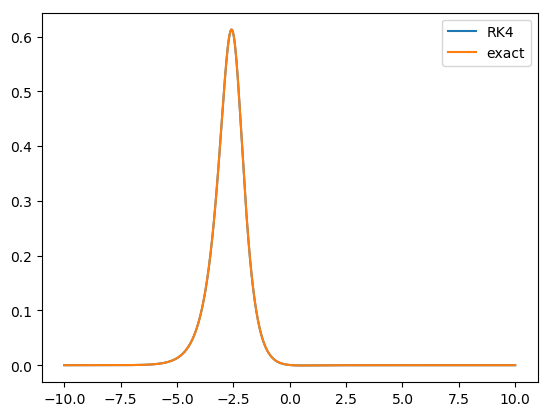

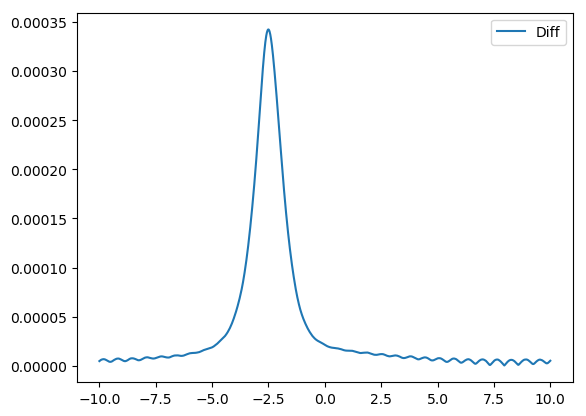

The maximum absolute error for our numerical solution vs. the exact solution is 0.0003424046465920294.


In [20]:
function rk4(NT, T, u, β, NX, L)
    dt = T / NT
    dx = L / NX
    t = dt * collect(0 : NT)
    x = dx * collect(-NX / 2 : NX / 2)
    for i = 1 : NT
        ui = u
        ti = t[i]
        k1 = f(ui, dx, β)
        k2 = f(ui + 0.5 * dt * k1, dx, β)
        k3 = f(ui + 0.5 * dt * k2, dx, β)
        k4 = f(ui + dt * k3, dx, β)
        u = ui + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)
    end
    return u
end

β = -8.0
a = β ^ 2 / 16
c = 0.5
x0 = -3.0

psiexact_func(x, t) = 2.0 * a / β * sech.(sqrt(a) * (x .- x0 .- c * t)) .* exp.(im * (c / 2.0 * (x .- x0) .- (c ^ 2 / 4.0 - a) * t))
 
Tf = 1.0
NT = 15000
L = 20
NX = 2000
dx = L / NX
xs = dx * collect(-NX / 2 : NX / 2)

psi0 = psiexact_func(xs, 0.0)
psi = rk4(NT, Tf, psi0, β, NX, L)
psiexact = psiexact_func(xs, Tf)

using PyPlot
figure(1)
plot(xs, real(psi), label = "RK4")
plot(xs, real(psiexact), label = "exact")
legend()

figure(2)
plot(xs, abs.(psi - psiexact), label = "Diff")
legend()

println("The maximum absolute error for our numerical solution vs. the exact solution is ", maximum(abs.(psi - psiexact)), ".")

As expected with these linear multistep methods, the error was greatest near where the higher-order derivatives of our solution were changing the largest, which is near the peak at $x = -3.0$.

___
**Part 2:** We now numerically solve the 1D nonlinear Schrödinger equation using an Implicit-Explicit (IMEX) method, where our implicit scheme is the trapezoidal rule, and the explicit scheme is the 2nd-order Adams-Bashforth method (AB2). Usually, for IMEX, we want to use the implicit scheme on the linear terms, and the explicit scheme on the nonlinear ones. Thus, we leave off from $(4)$ in part 1, except by defining different functions $f$ and $g$, where $f$ is linear and $g$ is nonlinear:

$$
\partial_t u_{i,j}=i\left(\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\left(\Delta x\right)^{2}}-\beta \vert u_{i,j}\vert^2 u_{i,j}\right):=f\left(u_{i,j}\right)+g\left(u_{i,j}\right) \hspace{0.5cm} (1) \\  f\left(u_{i,j}\right)=i\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\left(\Delta x\right)^{2}}, \quad g\left(u_{i,j}\right):=-i\beta \vert u_{i,j}\vert^2 u_{i,j}
$$

Now, with $f$ and $g$ defined in $(1)$, we can now discretize $(1)$ in time as well (i.e. $j$), such that for grid point $x_{i}$ (where we remind that $x_{i}\in\{x_{1},\dots,x_{m}\}$), our scheme looks like

$$
u_{i,j+1}=u_{i,j}+\frac{\Delta t}{2}\left(f\left(u_{i,j+1}\right)+f\left(u_{i,j}\right)\right)+\frac{3\Delta t}{2}g\left(u_{i,j}\right)-\frac{\Delta t}{2}g\left(u_{i,j-1}\right) \\ \Rightarrow u_{i,j+1}-\frac{\Delta t}{2}f\left(u_{i,j+1}\right)=u_{i,j}+\frac{\Delta t}{2}f\left(u_{i,j}\right)+\frac{3\Delta t}{2}g\left(u_{i,j}\right)-\frac{\Delta t}{2}g\left(u_{i,j-1}\right) \hspace{0.5cm} (2)
$$

As stated earlier, one can see that we have applied trapezoidal rule to the linear term $f$ and AB2 to the nonlinear term $g$. From here, we desire to write $(2)$ in the form of a matrix equation $A\overrightarrow{u}_{j+1}=\overrightarrow{b}_{j}$ to be solved at each timestep $j$, where $A\in\mathbb{R}^{m\times m}$, $\overrightarrow{u}_{j+1}=\begin{pmatrix} u_{1,j+1} \\ u_{2,j+1}  \\ \vdots \\ u_{m,j+1} \end{pmatrix}$, and $\overrightarrow{b}_{j}$ nonlinearly depends off of $\overrightarrow{u}_{j}$ and $\overrightarrow{u}_{j-1}$. We make this work by plugging in $f$ and $g$ directly into $(2)$.

$$
u_{i,j+1}-i\frac{\Delta t}{2}\left(\frac{u_{i+1,j+1}-2u_{i,j+1}+u_{i-1,j+1}}{\left(\Delta x\right)^{2}}\right)=u_{i,j}+\frac{i\Delta t}{2}\left(\frac{u_{i+1,j}-2u_{i,j}+u_{i-1,j}}{\left(\Delta x\right)^{2}}\right)-\frac{3i\beta\Delta t}{2}\vert u_{i,j}\vert^2 u_{i,j}+\frac{i\beta\Delta t}{2}\vert u_{i,j-1}\vert^2 u_{i,j-1} \\ 
\Rightarrow -\frac{i\Delta t}{2\left(\Delta x\right)^{2}}u_{i+1,j+1}+\left(1+\frac{i\Delta t}{\left(\Delta x\right)^{2}}\right)u_{i,j+1}-\frac{i\Delta t}{2\left(\Delta x\right)^{2}}u_{i-1,j+1}= \\ \frac{i\Delta t}{2\left(\Delta x\right)^{2}}u_{i+1,j}+\left(1-\frac{i\Delta t}{\left(\Delta x\right)^{2}}\right)u_{i,j}+\frac{i\Delta t}{2\left(\Delta x\right)^{2}}u_{i-1,j}-\frac{3i\beta\Delta t}{2}\vert u_{i,j}\vert^2 u_{i,j}+\frac{i\beta\Delta t}{2}\vert u_{i,j-1}\vert^2 u_{i,j-1} \hspace{0.5cm} (3)
$$

To impose periodic boundary conditions, note again that we have $u(x_{0},t)=u(x_{m},t)$ and $u(x_{m+1},t)=u(x_{1},t)$ $\forall t\in\left(0,T_{f}\right)$. Finally, writing $(3)$ into matrix form, we get

$$
\begin{pmatrix} 1+\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 0 & \cdots  & 0 & -\frac{i\Delta t}{{2\left(\Delta x \right)}^{2}} \\ -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1+\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & \ddots & \ddots & 0 \\ 0 & \ddots & \ddots & \ddots & \ddots & \vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\ 0 & \ddots & \ddots & -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1+\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} \\ -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 0 & \dots & 0 & -\frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1+\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} \end{pmatrix}\begin{pmatrix} u_{1,j+1} \\ u_{2,j+1}  \\ \vdots \\ u_{m,j+1} \end{pmatrix}= \\ \begin{pmatrix} 1-\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 0 & \cdots  & 0 & \frac{i\Delta t}{{2\left(\Delta x \right)}^{2}} \\ \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1-\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & \ddots & \ddots & 0 \\ 0 & \ddots & \ddots & \ddots & \ddots & \vdots \\ \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\ 0 & \ddots & \ddots & \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1-\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} & \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} \\ \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 0 & \dots & 0 & \frac{i\Delta t}{{2\left(\Delta x\right)}^{2}} & 1-\frac{i\Delta t}{{\left(\Delta x\right)}^{2}} \end{pmatrix}\begin{pmatrix} u_{1,j} \\ u_{2,j}  \\ \vdots \\ u_{m,j} \end{pmatrix}-\frac{3i\beta\Delta t}{2}\begin{pmatrix} \vert u_{1,j}\vert^2 u_{1,j} \\ \vert u_{2,j}\vert^2 u_{2,j} \\ \cdots \\ \vert u_{m,j}\vert^2 u_{m,j} \end{pmatrix}+\frac{i\beta\Delta t}{2}\begin{pmatrix} \vert u_{1,j-1}\vert^2 u_{1,j-1} \\ \vert u_{2,j-1}\vert^2 u_{2,j-1} \\ \cdots \\ \vert u_{m,j-1}\vert^2 u_{m,j-1} \end{pmatrix} \hspace{0.5cm} (4)
$$

$(4)$ is the matrix equation we desired of the form $A\overrightarrow{u}_{j+1}=\overrightarrow{b}_{j}$, which we can solve using GMRES at each timestep. Below, we will implement this IMEX scheme to solve numerically the 1D nonlinear Schrödinger equation and compare it with the true solution as given. Note that we will let $\overrightarrow{u}_{-1}=\overrightarrow{u}_{0}$, i.e. use a forward Euler predictor for the explicit, nonlinear part of our solver.

The maximum absolute error for our numerical solution vs. the exact solution is 

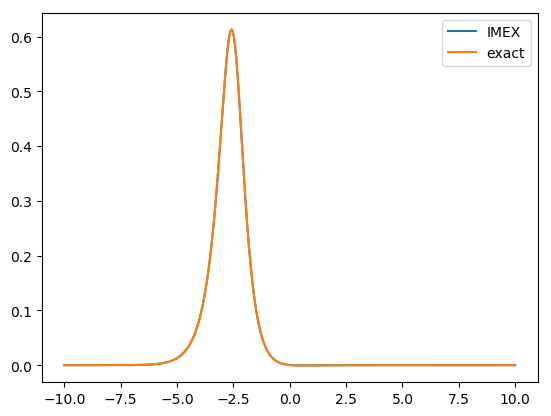

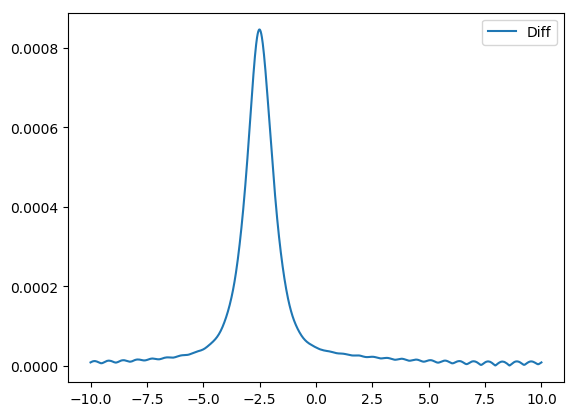

0.0008460278701896237.


In [1]:
using LinearAlgebra

#define GMRES
function GMRES(A, x, b, tol, maxit)
    m = length(b)
    #initialization for GMRES
    r = b - A * x
    error = norm(r) / norm(b)
    e_1 = complex(zeros(m + 1))
    e_1[1] = 1
    beta = norm(r) * e_1
    Q = complex(zeros(m, maxit + 1))
    H = complex(zeros(maxit + 1, maxit))
    Q[:, 1] = r / norm(r)
    #initialization for Givens rotation
    c = complex(zeros(maxit))
    s = complex(zeros(maxit))
    #GMRES iteration
    for i = 1 : maxit
        #Arnoldi process
        z = A * Q[:, i]
        for j = 1 : i
            H[j, i] = dot(Q[:, j], z)
            z = z - H[j, i] * Q[:, j]
        end
        H[i + 1, i] = norm(z)
        Q[:, i + 1] = z / H[i + 1, i]   
        
        #Givens rotation
        for j = 1 : i - 1 
            hi = c[j] * H[j, i] + s[j] * H[j + 1, i]
            H[j + 1, i] = -s[j] * H[j, i] + c[j] * H[j + 1, i]
            H[j, i] = hi
        end
        
        #Givens rotation matrix
        if (H[i, i] == 0)
            cterm = 0
            sterm = 1
        else
            cterm = abs(H[i, i]) / norm(H[i : i + 1, i])
            sterm = cterm * H[i + 1, i] / H[i, i]
        end
        H[i, i] = cterm * H[i, i] + sterm * H[i + 1, i]
        H[i + 1, i] = 0
        
        beta[i + 1] = -sterm * beta[i]
        beta[i] = cterm * beta[i]
        c[i] = cterm
        s[i] = sterm
        error  = abs(beta[i + 1]) / norm(b)
        if (error < tol)
            y = H[1 : i, 1 : i] \ beta[1 : i]
            x += Q[:, 1 : i] * y
            break
        end
    end
    return x
end

function IMEX(NT, T, NX, L, u, β, tol, maxit)
    m = length(u)
    dt = T / NT
    dx = L / NX
    t = dt * collect(0 : NT)
    x = dx * collect(-NX / 2 : NX / 2)
    Aleft = complex(zeros(m, m))
    Aright = complex(zeros(m, m))
    factor = im * dt / dx ^ 2
    #create A (Aleft) and the mxm matrix which multiples u_j at each timestep (Aright)
    Aleft[:, 1] = [1 + factor; -factor / 2; complex(zeros(m - 3)); -factor / 2]
    Aleft[:, m] = [-factor / 2; complex(zeros(m - 3)); -factor / 2; 1 + factor]
    Aright[:, 1] = [1 - factor; factor / 2; complex(zeros(m - 3)); factor / 2]
    Aright[:, m] = [factor / 2; complex(zeros(m - 3)); factor / 2; 1 - factor]
    for j = 2 : m - 1
        Aleft[j - 1, j] = -factor / 2
        Aleft[j, j] = 1 + factor
        Aleft[j + 1, j] = -factor / 2
        Aright[j - 1, j] = factor / 2
        Aright[j, j] = 1 - factor
        Aright[j + 1, j] = factor / 2
    end
    #now, we write out the timestepping scheme
    ui = u
    for i = 1 : NT
        b = Aright * u - (3 * im * β * dt / 2) * abs2.(u) .* u + (im * β * dt / 2) * abs2.(ui) .* ui
        uf = GMRES(Aleft, u, b, tol, maxit)
        ui = u
        u = uf
    end
    return u
end

β = -8.0
a = β ^ 2 / 16
c = 0.5
x0 = -3.0

psiexact_func(x, t) = 2.0 * a / β * sech.(sqrt(a) * (x .- x0 .- c * t)) .* exp.(im * (c / 2.0 * (x .- x0) .- (c ^ 2 / 4.0 - a) * t))

tol = 1e-12
maxit = 100
Tf = 1.0
NT = 1000
L = 20
NX = 1500
dx = L / NX
xs = dx * collect(-NX / 2 : NX / 2)

psi0 = psiexact_func(xs, 0.0)
psi = IMEX(NT, Tf, NX, L, psi0, β, tol, maxit)
psiexact = psiexact_func(xs, Tf)

using PyPlot
figure(1)
plot(xs, real(psi), label = "IMEX")
plot(xs, real(psiexact), label = "exact")
legend()

figure(2)
plot(xs, abs.(psi - psiexact), label = "Diff")
legend()

println("The maximum absolute error for our numerical solution vs. the exact solution is ", maximum(abs.(psi - psiexact)), ".")

Notice how, while the implementation was more complex because of GMRES, the IMEX method gave just as accurate of a solution with under 10% of the timesteps as required for RK4.